Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

Data Input and Preprocessing

In [ ]:
# Load your dataset (adjust the path as needed)
train_data = '/content/diabetes (1).csv'

# Load data and preprocess
df = pd.read_csv(train_data)
X = df.drop('Outcome', axis=1)  # Assuming 'Outcome' is the target column
y = df['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Training and Test Split

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Build the Neural Network model using Keras Sequential API

In [ ]:

model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))


model.add(Dropout(0.1))
model.add(Dense(units=3, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train, epochs=40, batch_size=32,
    validation_data=(X_test, y_test), callbacks=[early_stopping]

)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6661 - loss: 0.9560 - val_accuracy: 0.6429 - val_loss: 0.9389
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6695 - loss: 0.9278 - val_accuracy: 0.6429 - val_loss: 0.9126
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6318 - loss: 0.9078 - val_accuracy: 0.6429 - val_loss: 0.8896
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6637 - loss: 0.8842 - val_accuracy: 0.6429 - val_loss: 0.8681
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6609 - loss: 0.8551 - val_accuracy: 0.6429 - val_loss: 0.8485
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6502 - loss: 0.8455 - val_accuracy: 0.6429 - val_loss: 0.8292
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6533 - loss: 0.8213 - val_accuracy: 0.6429 - val_loss: 0.8113
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6476 - loss: 0.8044 - val_accuracy: 0.6429 - val_loss

XGBoost Model

In [ ]:

# Define XGBoost model (without fitting yet)
xgb_model = xgb.XGBClassifier(objective='binary:logistic')  # Adjust objective for regression if needed

# Hyperparameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 8],
    'n_estimators': [100, 200, 400]
}  # Example hyperparameters, adjust as needed

# Perform GridSearchCV with XGBoost
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best XGBoost Model Parameters:", best_params)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate performance
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

Best XGBoost Model Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        99
           1       0.67      0.65      0.66        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



Model and Parameters

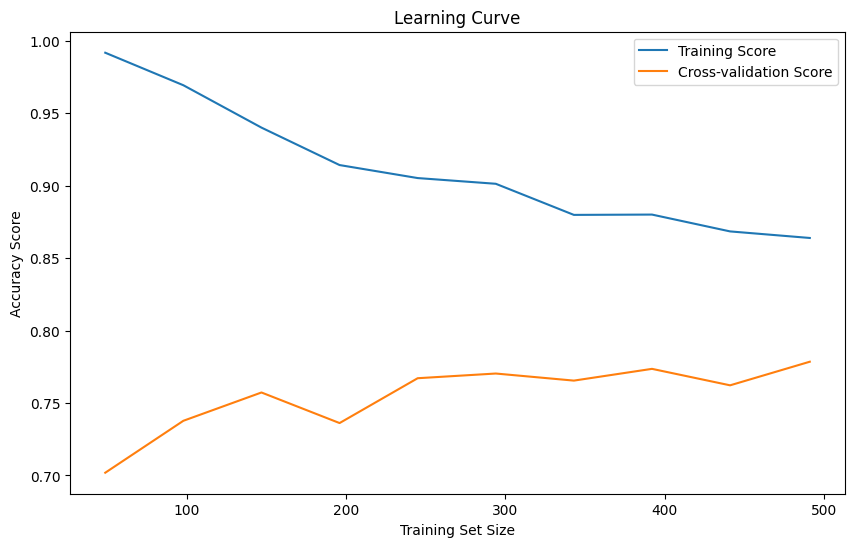

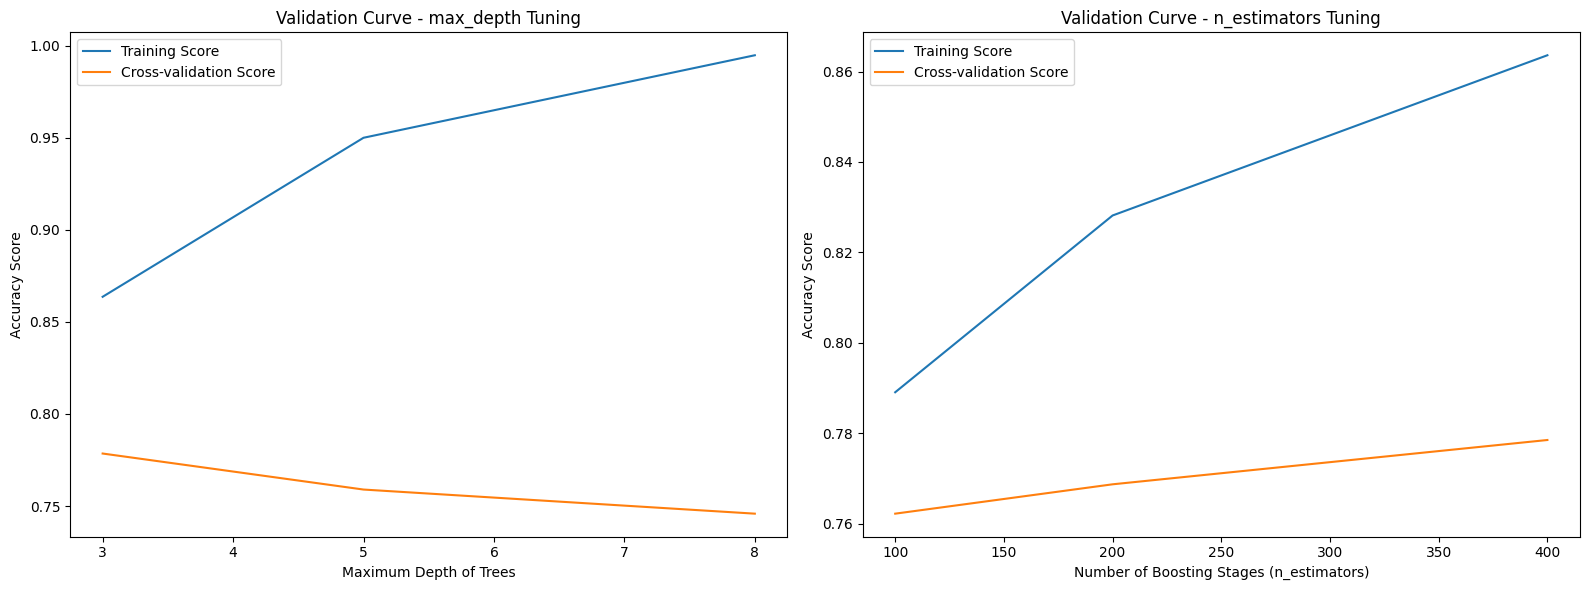

In [ ]:


# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Validation Curve with Relevant Hyperparameters
param_range_depth = [3, 5, 8]  # Example hyperparameter range for max_depth
param_range_n_estimators = [100, 200, 400]  # Example hyperparameter range for n_estimators

# Validation Curve for max_depth
train_scores_depth, test_scores_depth = validation_curve(
    best_model, X_train, y_train, param_name='max_depth', param_range=param_range_depth, cv=5, scoring='accuracy'
)

# Validation Curve for n_estimators
train_scores_n_estimators, test_scores_n_estimators = validation_curve(
    best_model, X_train, y_train, param_name='n_estimators', param_range=param_range_n_estimators, cv=5, scoring='accuracy'
)

# Plotting
plt.figure(figsize=(16, 6))

# Plot Validation Curve for max_depth
plt.subplot(1, 2, 1)
plt.plot(param_range_depth, np.mean(train_scores_depth, axis=1), label='Training Score')
plt.plot(param_range_depth, np.mean(test_scores_depth, axis=1), label='Cross-validation Score')
plt.xlabel('Maximum Depth of Trees')
plt.ylabel('Accuracy Score')
plt.title('Validation Curve - max_depth Tuning')
plt.legend()

# Plot Validation Curve for n_estimators
plt.subplot(1, 2, 2)
plt.plot(param_range_n_estimators, np.mean(train_scores_n_estimators, axis=1), label='Training Score')
plt.plot(param_range_n_estimators, np.mean(test_scores_n_estimators, axis=1), label='Cross-validation Score')
plt.xlabel('Number of Boosting Stages (n_estimators)')
plt.ylabel('Accuracy Score')
plt.title('Validation Curve - n_estimators Tuning')
plt.legend()
plt.tight_layout()
plt.show()